In [1]:
from tqdm.notebook import tqdm
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import matplotlib.font_manager as fm

font_name = fm.FontProperties(fname=r"C:\Windows\Fonts\malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import time
import random
from tqdm import tqdm_notebook

import folium
from IPython.display import display

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import os
import traceback

## 서울 어린이집 데이터 불러오기

In [2]:
center = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414).xls")

In [3]:
# center.head()

In [4]:
del center["어린이집명"]
del center["우편번호"]
del center["주소"]
del center["어린이집전화번호"]
del center["어린이집팩스번호"]
del center["보육실수"]
del center["정원수"]
del center["현원수"]
del center["위도"]
del center["경도"]

del center["운영현황"]
del center["보육실면적"]
del center["놀이터수"]
del center["보육교직원수"]

del center["통학차량운영여부"]
del center["홈페이지주소"]
del center["인가일자"]
del center["휴지시작일자"]
del center["휴지종료일자"]

In [5]:
center

,시도,시군구,어린이집유형구분,폐지일자
0,서울특별시,송파구,법인·단체등,NaN
1,서울특별시,송파구,민간,2013-05-31
2,서울특별시,송파구,민간,2012-03-15
3,서울특별시,성북구,직장,NaN
4,서울특별시,영등포구,가정,2021-05-27
...,...,...,...,...
9393,서울특별시,금천구,가정,NaN
9394,서울특별시,은평구,가정,2014-06-13
9395,서울특별시,강남구,협동,NaN
9396,서울특별시,서초구,민간,2015-07-25


In [6]:
center_c = center.dropna()

In [7]:
center_c.head()

,시도,시군구,어린이집유형구분,폐지일자
1,서울특별시,송파구,민간,2013-05-31
2,서울특별시,송파구,민간,2012-03-15
4,서울특별시,영등포구,가정,2021-05-27
7,서울특별시,관악구,민간,2015-04-01
9,서울특별시,성동구,민간,2022-03-20


In [8]:
center_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4606 entries, 1 to 9397
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   시도        4606 non-null   object
 1   시군구       4606 non-null   object
 2   어린이집유형구분  4606 non-null   object
 3   폐지일자      4606 non-null   object
dtypes: object(4)
memory usage: 179.9+ KB


In [9]:
# 폐지일자 날짜 타입으로 변경
center_c["폐지일자"] = pd.to_datetime(center_c["폐지일자"])

C:\Users\acorn\AppData\Local\Temp\ipykernel_11324\3256599212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_c["폐지일자"] = pd.to_datetime(center_c["폐지일자"])


In [10]:
# 타입 변경 확인
center_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4606 entries, 1 to 9397
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   시도        4606 non-null   object        
 1   시군구       4606 non-null   object        
 2   어린이집유형구분  4606 non-null   object        
 3   폐지일자      4606 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 179.9+ KB


In [11]:
# 폐지일자가 있는 수를 구별로 카운트
center_c.groupby("시군구")[["폐지일자"]].count()

,폐지일자
시군구,
강남구,176
강동구,193
강북구,124
강서구,286
관악구,220
광진구,146
구로구,203
금천구,142
노원구,350


In [12]:
# 일자 순으로 정렬
center_c = center_c.sort_values("폐지일자")

In [13]:
center_c.head()

,시도,시군구,어린이집유형구분,폐지일자
7745,서울특별시,강남구,민간,1990-09-20
7415,서울특별시,동작구,가정,1993-12-15
1867,서울특별시,동작구,국공립,1996-01-31
4005,서울특별시,동작구,가정,1996-02-15
5702,서울특별시,마포구,가정,1996-12-17


In [14]:
# 타입 한번 더 확인
print(center_c["폐지일자"].dtype)

datetime64[ns]


## 연도별 어린이집 폐지 수

- 데이터 내 첫 폐지 연도인 1990년으로 시작

In [15]:
y = ["1990", "1991", "1993", "1994", "1995", "1996", "1997", "1998", "1999", 
     "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009",
     "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019",
     "2020", "2021", "2022", "2023"]

In [16]:
for i in range(0, len(y)):
    print(f"{y[i]}년 폐지 수 :", center_c.loc[center_c["폐지일자"].between(f"{y[i]}-01-01", f"{y[i]}-12-31")].count()[3])

1990년 폐지 수 : 1
1991년 폐지 수 : 0
1993년 폐지 수 : 1
1994년 폐지 수 : 0
1995년 폐지 수 : 0
1996년 폐지 수 : 3
1997년 폐지 수 : 3
1998년 폐지 수 : 4
1999년 폐지 수 : 7
2000년 폐지 수 : 4
2001년 폐지 수 : 0
2002년 폐지 수 : 0
2003년 폐지 수 : 2
2004년 폐지 수 : 2
2005년 폐지 수 : 1
2006년 폐지 수 : 1
2007년 폐지 수 : 20
2008년 폐지 수 : 98
2009년 폐지 수 : 145
2010년 폐지 수 : 117
2011년 폐지 수 : 127
2012년 폐지 수 : 105
2013년 폐지 수 : 125
2014년 폐지 수 : 179
2015년 폐지 수 : 261
2016년 폐지 수 : 417
2017년 폐지 수 : 402
2018년 폐지 수 : 494
2019년 폐지 수 : 537
2020년 폐지 수 : 527
2021년 폐지 수 : 408
2022년 폐지 수 : 421
2023년 폐지 수 : 194


## 서울 포함 전국 비교

In [17]:
center = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414).xls")

In [18]:
center1 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (1).xls")

In [19]:
center2 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (2).xls")

In [20]:
center3 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (3).xls")

In [21]:
center4 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (4).xls")

In [22]:
center5 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (5).xls")

In [23]:
center6 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (6).xls")

In [24]:
center7 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (7).xls")

In [25]:
center8 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (8).xls")

In [26]:
center9 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (9).xls")

In [27]:
center10 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (10).xls")

In [28]:
center11 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (11).xls")

In [29]:
center12 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (12).xls")

In [30]:
center13 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (13).xls")

In [31]:
center14 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (14).xls")

In [32]:
center15 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (15).xls")

In [33]:
center16 = pd.read_excel("./data/어린이집기본정보조회(비정기)-기준일(20230414) (16).xls")

In [34]:
center_total = pd.concat([center, center1, center2, center3, center4, center5, center6, center7, center8, center9, center10, center11, center12, center13, center14, center15, center16])

In [35]:
center_total

,시도,시군구,어린이집명,어린이집유형구분,운영현황,우편번호,주소,어린이집전화번호,어린이집팩스번호,보육실수,...,정원수,현원수,위도,경도,통학차량운영여부,홈페이지주소,인가일자,휴지시작일자,휴지종료일자,폐지일자
0,서울특별시,송파구,(재)천주교서울대교구유지재단천사어린이집,법인·단체등,정상,5753.0,서울특별시 송파구 거마로24길 11 (마천동),02-409-1406,02-409-1507,5,...,61,48,37.499314,127.149096,미운영,http://cafe.daum.net/angel1406,2006-04-27,NaN,NaN,NaN
1,서울특별시,송파구,0세교육어린이집,민간,폐지,5694.0,서울특별시 송파구 송파대로37길 90,02-416-2223,--,3,...,21,0,37.498939,127.102530,미운영,NaN,1999-04-20,NaN,NaN,2013-05-31
2,서울특별시,송파구,0세아카데미어린이집,민간,폐지,5600.0,서울특별시 송파구 백제고분로21길 24 (삼전동),02-2202-4921,02-420-6903,5,...,39,0,37.505872,127.090868,NaN,http://cafe.daum.net/wyskindergaten,1996-02-16,NaN,NaN,2012-03-15
3,서울특별시,성북구,101경비단 어린이집,직장,정상,2812.0,서울특별시 성북구 정릉로10라길 18-5,02-911-2101,02-909-4101,10,...,100,30,37.605560,126.999434,미운영,https://www.puruni.com/smpa101,2022-03-07,NaN,NaN,NaN
4,서울특별시,영등포구,123목화어린이집,가정,폐지,7385.0,서울특별시 영등포구 신길로45길 4-2,02-849-9111,02-849-9112,3,...,16,0,37.509624,126.910143,미운영,NaN,2012-12-05,NaN,NaN,2021-05-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17560,경기도,수원시영통구,힐스행복어린이집,가정,정상,16685.0,"경기도 수원시 영통구 덕영대로 1462-14 115동 103호(망포동, 힐스테이트영통)",031-203-9930,--,3,...,20,19,37.241680,127.047114,미운영,NaN,2017-10-25,NaN,NaN,NaN
17561,경기도,남양주시,힐즈파크어린이집,민간,폐지,12177.0,경기도 남양주시 화도읍 비룡로33번길 25 힐즈파크어린이집(힐즈파크푸르지오),031-511-7795,0504-360-7210,6,...,78,0,37.655268,127.297935,미운영,NaN,2018-05-18,NaN,NaN,2020-04-01
17562,경기도,남양주시,힘멜에듀센터어린이집,민간,폐지,12208.0,경기도 남양주시 와부읍 덕소로97번길 69,031-576-6777,031-576-6776,8,...,115,0,37.589196,127.220481,운영,NaN,2008-03-05,NaN,NaN,2020-03-03
17563,경기도,수원시권선구,힘찬어린이집,가정,폐지,16594.0,경기도 수원시 권선구 덕영대로997번길 47 양천연립101호 (세류동),031-223-7303,031-624-0618,3,...,15,0,37.259001,127.006704,운영,NaN,2008-10-10,NaN,NaN,2015-03-25


In [36]:
del center_total["어린이집명"]
del center_total["우편번호"]
del center_total["주소"]
del center_total["어린이집전화번호"]
del center_total["어린이집팩스번호"]
del center_total["보육실수"]
del center_total["정원수"]
del center_total["현원수"]
del center_total["위도"]
del center_total["경도"]

del center_total["운영현황"]
del center_total["보육실면적"]
del center_total["놀이터수"]
del center_total["보육교직원수"]

del center_total["통학차량운영여부"]
del center_total["홈페이지주소"]
del center_total["인가일자"]
del center_total["휴지시작일자"]
del center_total["휴지종료일자"]

In [37]:
center_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58681 entries, 0 to 17564
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   시도        58681 non-null  object
 1   시군구       58681 non-null  object
 2   어린이집유형구분  58681 non-null  object
 3   폐지일자      27900 non-null  object
dtypes: object(4)
memory usage: 2.2+ MB


In [38]:
center_total = center_total.dropna()

In [39]:
center_total["폐지일자"] = pd.to_datetime(center_total["폐지일자"])

C:\Users\acorn\AppData\Local\Temp\ipykernel_11324\2909686630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_total["폐지일자"] = pd.to_datetime(center_total["폐지일자"])


In [40]:
y = ["1990", "1991", "1993", "1994", "1995", "1996", "1997", "1998", "1999", 
     "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009",
     "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019",
     "2020", "2021", "2022", "2023"]


for i in range(0, len(y)):
    print(f"{y[i]}년 폐지 수 :", center_total.loc[center_total["폐지일자"].between(f"{y[i]}-01-01", f"{y[i]}-12-31")].count()[3])

1990년 폐지 수 : 1
1991년 폐지 수 : 0
1993년 폐지 수 : 1
1994년 폐지 수 : 0
1995년 폐지 수 : 1
1996년 폐지 수 : 7
1997년 폐지 수 : 8
1998년 폐지 수 : 7
1999년 폐지 수 : 19
2000년 폐지 수 : 7
2001년 폐지 수 : 10
2002년 폐지 수 : 10
2003년 폐지 수 : 13
2004년 폐지 수 : 15
2005년 폐지 수 : 7
2006년 폐지 수 : 16
2007년 폐지 수 : 76
2008년 폐지 수 : 329
2009년 폐지 수 : 607
2010년 폐지 수 : 1573
2011년 폐지 수 : 529
2012년 폐지 수 : 495
2013년 폐지 수 : 682
2014년 폐지 수 : 1120
2015년 폐지 수 : 1874
2016년 폐지 수 : 2248
2017년 폐지 수 : 1987
2018년 폐지 수 : 2410
2019년 폐지 수 : 3170
2020년 폐지 수 : 3238
2021년 폐지 수 : 2867
2022년 폐지 수 : 3041
2023년 폐지 수 : 1527


In [41]:
# y = ["1990", "1991", "1993", "1994", "1995", "1996", "1997", "1998", "1999", 
#      "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009",
#      "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019",
#      "2020", "2021", "2022", "2023"]

# for i in range(0, len(y)):
#     print(f"{y[i]}")
# for i in range(0, len(y)):    
#     print(center_total.loc[center_total["폐지일자"].between(f"{y[i]}-01-01", f"{y[i]}-12-31")].count()[3])

In [42]:
uu = pd.read_excel("./data/연도별_전국_어린이집폐지.xlsx")

In [43]:
uu1 = uu.set_index("연도")

Text(33, 1500, '2023 - 1/4')

<Figure size 2000x1500 with 0 Axes>

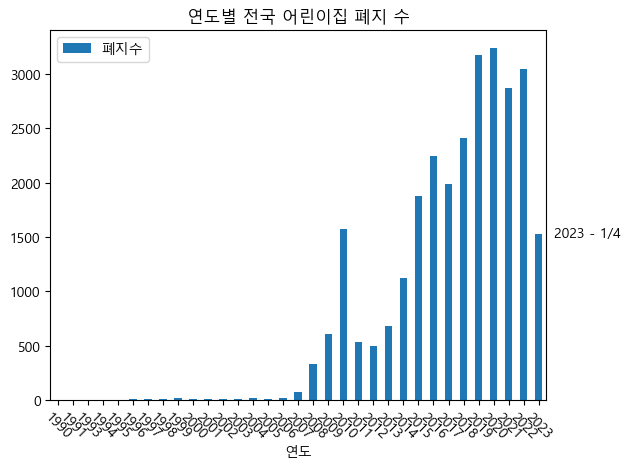

In [44]:
plt.figure(figsize = (20, 15))
uu1.plot(kind="bar")
plt.xticks(rotation = -45)
plt.title("연도별 전국 어린이집 폐지 수")
plt.text(33,1500, "2023 - 1/4")

Text(33, 1500, '2023 - 1/4')

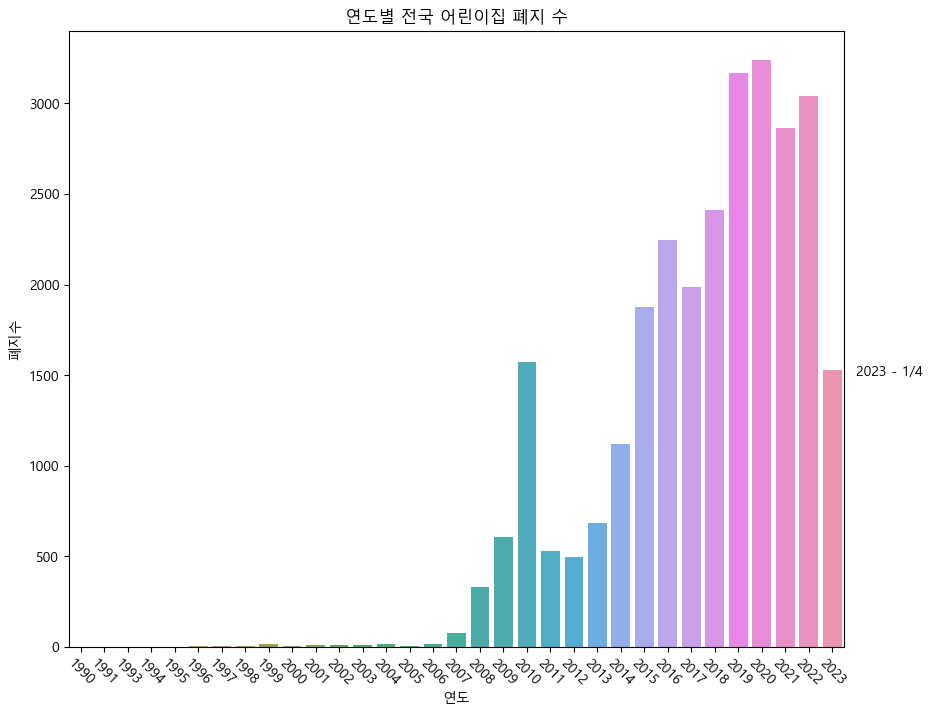

In [45]:
plt.figure(figsize = (10, 8))
sns.barplot(x="연도", y="폐지수", data=uu)
plt.xticks(rotation = -45)
plt.title("연도별 전국 어린이집 폐지 수")
plt.text(33,1500, "2023 - 1/4")